In [1]:
import cv2

import matplotlib.pyplot as plt

import numpy as np

import os

from PIL import Image

from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform

## Don't forget to run feature extraction before running this script
```python extract_features.py --image_list_file image_list_qualitative.txt```

### Change the pair index here (possible values: 1, 2 or 3)

In [2]:
pair_idx = 2
assert(pair_idx in [1, 2, 3])

### Loading the features

In [3]:
pair_path = os.path.join('images', 'pair_%d' % pair_idx)

In [4]:
image1 = np.array(Image.open(os.path.join(pair_path, '1.jpg')))
image2 = np.array(Image.open(os.path.join(pair_path, '2.jpg')))

In [5]:
feat1 = np.load(os.path.join(pair_path, '1.jpg.d2-net'))
feat2 = np.load(os.path.join(pair_path, '2.jpg.d2-net'))

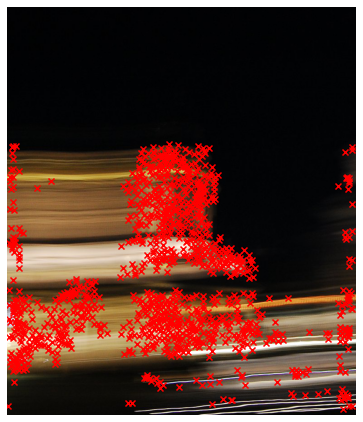

In [6]:
plt.figure(figsize=(7.5, 7.5))
plt.imshow(image1, cmap='gray')
plt.scatter(feat1['keypoints'][:, 0], feat1['keypoints'][:, 1], marker='x', c='r')
plt.axis('off')
plt.show()

### Mutual nearest neighbors matching

In [7]:
matches = match_descriptors(feat1['descriptors'], feat2['descriptors'], cross_check=True)

In [8]:
print('Number of raw matches: %d.' % matches.shape[0])

Number of raw matches: 225.


### Homography fitting

In [9]:
keypoints_left = feat1['keypoints'][matches[:, 0], : 2]
keypoints_right = feat2['keypoints'][matches[:, 1], : 2]
np.random.seed(0)
model, inliers = ransac(
    (keypoints_left, keypoints_right),
    ProjectiveTransform, min_samples=4,
    residual_threshold=4, max_trials=10000
)
n_inliers = np.sum(inliers)
print('Number of inliers: %d.' % n_inliers)

Number of inliers: 50.


### Plotting

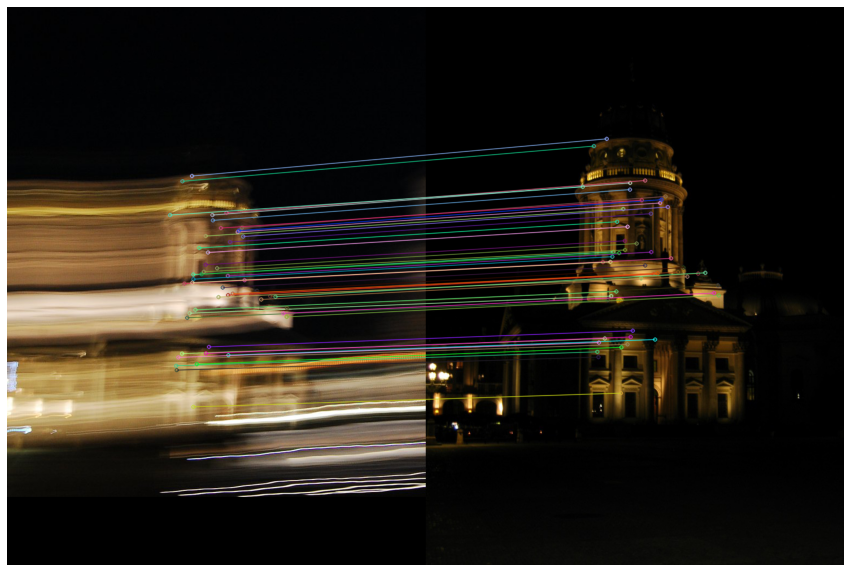

In [10]:
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(image1, inlier_keypoints_left, image2, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(15, 15))
plt.imshow(image3)
plt.axis('off')
plt.show()